In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-13 18:54:37.031892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 18:54:37.310537: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 18:54:38.119818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

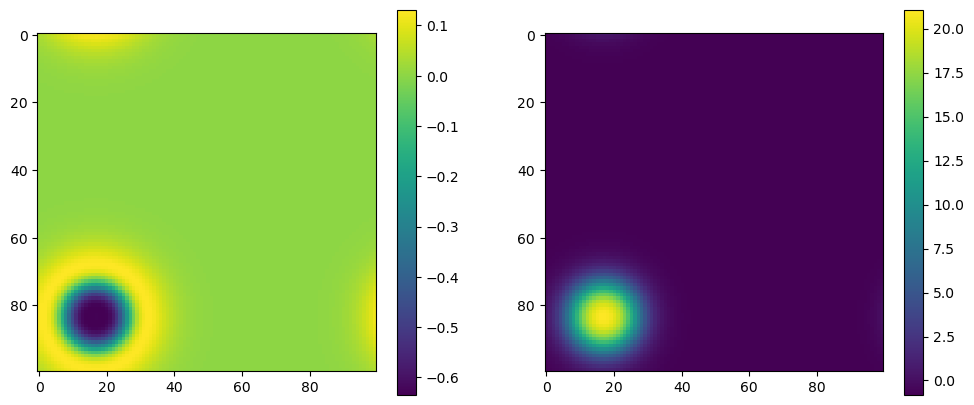

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [5]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [6]:
H.shape

TensorShape([2, 100, 100, 3])

In [7]:
def grads(pinn, inputs):
    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))

In [8]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            outputs = tf.matmul(H, W)
            H = tf.tanh(a*outputs + b)

        W = self.weights[-1]
        a = self.scales[-1]
        b = self.biases[-1]
        outputs = tf.matmul(H, W)
        outputs = a*outputs + b*b/2.0
        return outputs

In [15]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)

In [16]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

init_per = 1.0
sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)


@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 1]
            u_y = grad_u[:, 0]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 1]
            v_y = grad_v[:, 0]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 1]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 0]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 1]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 0]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        #print(u)
        #print(u_xx)
        f = u * u * v / (1.0 + kappa_u * u * u)
        #print(u_xx.shape)
        #print(f.shape)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
#         u_diff = u - elements[1][:, 0, :, :]
#         v_diff = v - elements[1][:, 1, :, :]
#         l2_u_obs = tf.reduce_sum(u_diff**2)
#         l2_v_obs = tf.reduce_sum(v_diff**2)

                
        #l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        l2 = l2_res_u + l2_res_v
        
    #print(trainables)  
    grads = tape.gradient(l2, trainables)

#     print("=================================")
#     print(list(grads))
#     print()
    optimizer.apply_gradients(zip(grads, trainables))
    #return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    return (l2_res_u, l2_res_v)

In [17]:
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

In [18]:
data.shape

TensorShape([20000, 3])

In [19]:
c = pattern.c.reshape(2, pattern.c.shape[1]*pattern.c.shape[2]*pattern.c.shape[3]).T
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,)))

In [20]:
batch_size = 10000
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
           )
    
losses = tu.train(epochs=20000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 277314.5284423828  u: 3506.0333251953125,  v: 273808.4951171875,

Time taken: 66.98s

Start of epoch 100
at epoch 100
 total loss: 98224.92388534546  u: 117.63193893432617,  v: 98107.29194641113,

Time taken: 12.97s

Start of epoch 200
at epoch 200
 total loss: 98075.19317245483  u: 94.77370071411133,  v: 97980.41947174072,

Time taken: 13.09s

Start of epoch 300
at epoch 300
 total loss: 98049.97278046608  u: 89.98711609840393,  v: 97959.98566436768,

Time taken: 12.98s

Start of epoch 400
at epoch 400
 total loss: 98194.97814750671  u: 99.27369499206543,  v: 98095.70445251465,

Time taken: 13.94s

Start of epoch 500
at epoch 500
 total loss: 98032.50573086739  u: 87.57423138618469,  v: 97944.9314994812,

Time taken: 14.35s

Start of epoch 600
at epoch 600
 total loss: 98027.91573762894  u: 86.90274095535278,  v: 97941.01299667358,

Time taken: 13.90s

Start of epoch 700
at epoch 700
 total loss: 98025.94063043594  u: 86.1507363319397,  v: 979


Start of epoch 6300
at epoch 6300
 total loss: 98094.88285183907  u: 79.1946804523468,  v: 98015.68817138672,

Time taken: 16.42s

Start of epoch 6400
at epoch 6400
 total loss: 98041.00503754616  u: 79.29873490333557,  v: 97961.70630264282,

Time taken: 16.57s

Start of epoch 6500
at epoch 6500
 total loss: 98000.70378863811  u: 78.91344439983368,  v: 97921.79034423828,

Time taken: 16.43s

Start of epoch 6600
at epoch 6600
 total loss: 98009.00337255001  u: 78.83218038082123,  v: 97930.17119216919,

Time taken: 14.62s

Start of epoch 6700
at epoch 6700
 total loss: 98049.37975013256  u: 79.1725891828537,  v: 97970.2071609497,

Time taken: 14.71s

Start of epoch 6800
at epoch 6800
 total loss: 98021.1552541256  u: 79.0315625667572,  v: 97942.12369155884,

Time taken: 14.64s

Start of epoch 6900
at epoch 6900
 total loss: 98004.22861135006  u: 79.05158269405365,  v: 97925.177028656,

Time taken: 15.19s

Start of epoch 7000
at epoch 7000
 total loss: 98081.63536584377  u: 79.3517507314


Start of epoch 12500
at epoch 12500
 total loss: 98002.08050251007  u: 78.65662479400635,  v: 97923.42387771606,

Time taken: 12.95s

Start of epoch 12600
at epoch 12600
 total loss: 98011.21714508533  u: 78.7419902086258,  v: 97932.47515487671,

Time taken: 12.74s

Start of epoch 12700
at epoch 12700
 total loss: 98280.01083636284  u: 79.57383990287781,  v: 98200.43699645996,

Time taken: 12.89s

Start of epoch 12800
at epoch 12800
 total loss: 98000.78041172028  u: 78.73782062530518,  v: 97922.04259109497,

Time taken: 13.11s

Start of epoch 12900
at epoch 12900
 total loss: 98001.35042273998  u: 78.6711128950119,  v: 97922.67930984497,

Time taken: 12.81s

Start of epoch 13000
at epoch 13000
 total loss: 98005.11696445942  u: 78.61504185199738,  v: 97926.50192260742,

Time taken: 12.93s

Start of epoch 13100
at epoch 13100
 total loss: 98004.25031232834  u: 78.65107679367065,  v: 97925.59923553467,

Time taken: 12.96s

Start of epoch 13200
at epoch 13200
 total loss: 98040.85471582


Start of epoch 18700
at epoch 18700
 total loss: 98002.13808357716  u: 78.53548347949982,  v: 97923.60260009766,

Time taken: 11.95s

Start of epoch 18800
at epoch 18800
 total loss: 97999.54151391983  u: 78.60866403579712,  v: 97920.93284988403,

Time taken: 10.98s

Start of epoch 18900
at epoch 18900
 total loss: 98010.60559511185  u: 78.53764390945435,  v: 97932.06795120239,

Time taken: 10.71s

Start of epoch 19000
at epoch 19000
 total loss: 97996.16849064827  u: 78.52358937263489,  v: 97917.64490127563,

Time taken: 10.87s

Start of epoch 19100
at epoch 19100
 total loss: 97997.79745590687  u: 78.52052414417267,  v: 97919.2769317627,

Time taken: 10.70s

Start of epoch 19200
at epoch 19200
 total loss: 98061.28744387627  u: 78.80218386650085,  v: 97982.48526000977,

Time taken: 11.16s

Start of epoch 19300
at epoch 19300
 total loss: 97998.34021782875  u: 78.51279854774475,  v: 97919.827419281,

Time taken: 10.84s

Start of epoch 19400
at epoch 19400
 total loss: 97997.470732331

In [21]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

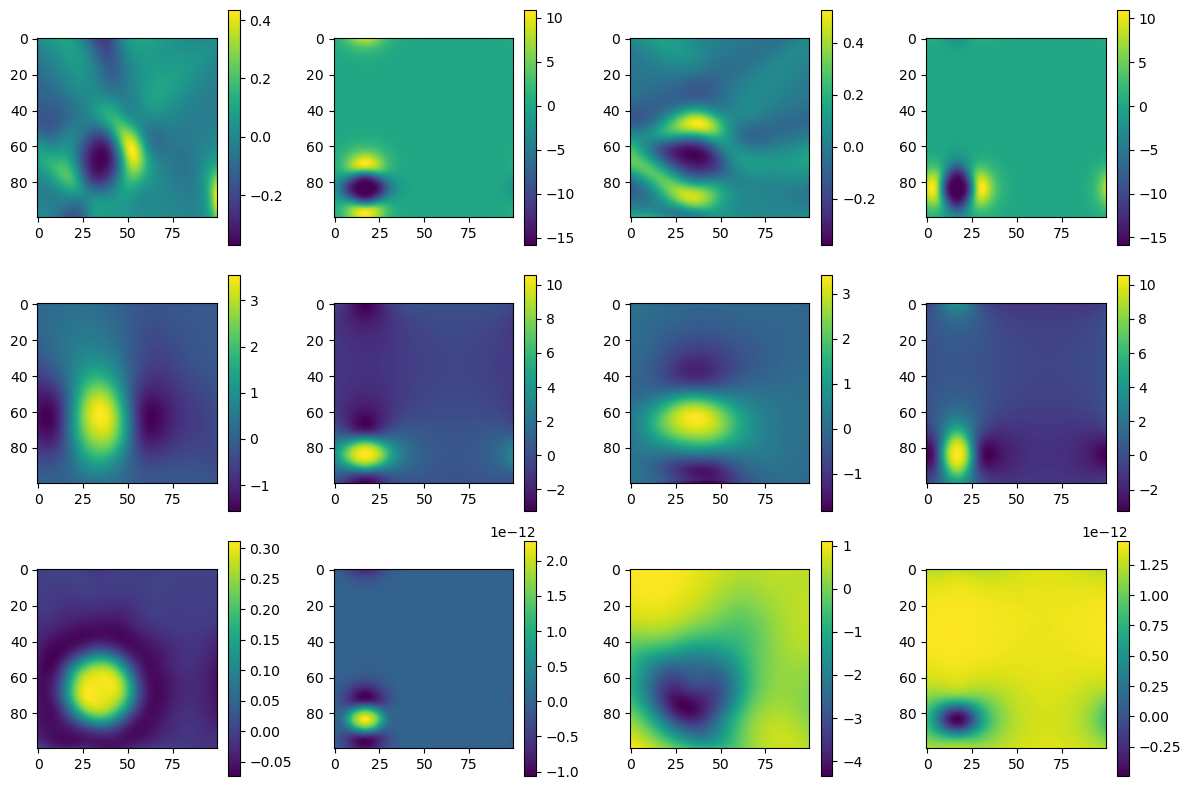

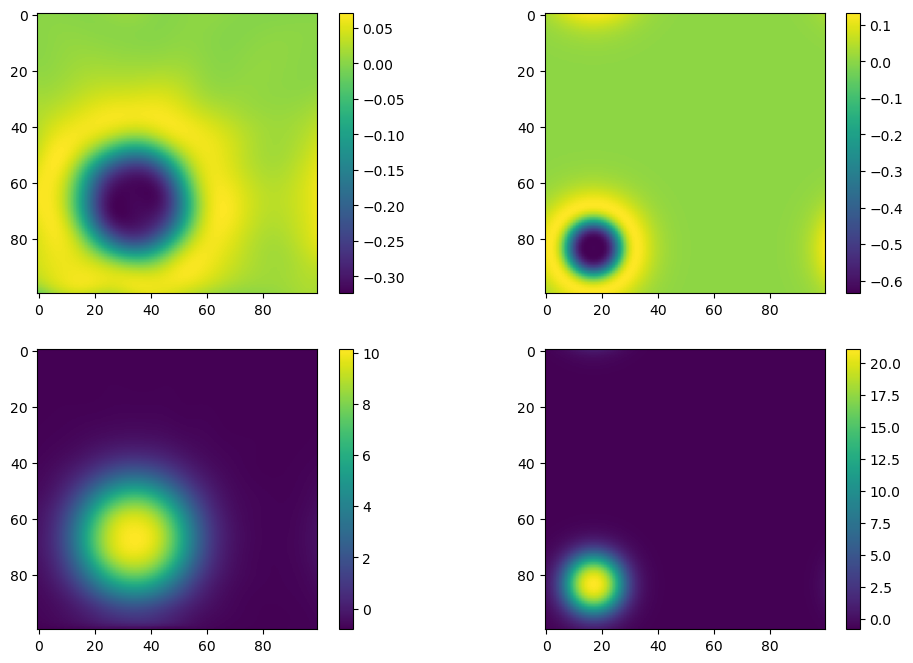

In [22]:
def to(arr):
    return arr.numpy().reshape(pattern.t_star.shape[0], x_range.shape[0], y_range.shape[0])

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx)[-1, ...])
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy)[-1, ...])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx)[-1, ...])
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy)[-1, ...])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t)[-1, ...])
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t)[-1, ...])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(pattern.params["D_u"]*( to(u_xx)[-1, ...] + to(u_yy)[-1, ...]) - to(u_t)[-1, ...])
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.params["D_v"]*( to(v_xx)[-1, ...] + to(v_yy)[-1, ...]) - to(v_t)[-1, ...])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [23]:
losses2 = tu.train(epochs=20000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 98001.21677982807  u: 78.56860935688019,  v: 97922.64817047119,

Time taken: 46.32s

Start of epoch 100
at epoch 100
 total loss: 97992.60615956783  u: 78.50418508052826,  v: 97914.1019744873,

Time taken: 11.11s

Start of epoch 200
at epoch 200
 total loss: 98011.56484222412  u: 78.54206848144531,  v: 97933.02277374268,

Time taken: 11.25s

Start of epoch 300
at epoch 300
 total loss: 97993.66001141071  u: 78.49640667438507,  v: 97915.16360473633,

Time taken: 11.03s

Start of epoch 400
at epoch 400
 total loss: 98007.89097547531  u: 78.55268049240112,  v: 97929.33829498291,

Time taken: 10.51s

Start of epoch 500
at epoch 500
 total loss: 97996.70934271812  u: 78.6382749080658,  v: 97918.07106781006,

Time taken: 10.87s

Start of epoch 600
at epoch 600
 total loss: 97992.45114970207  u: 78.56877207756042,  v: 97913.88237762451,

Time taken: 10.53s

Start of epoch 700
at epoch 700
 total loss: 97993.2076548338  u: 78.5269945859909,  v: 97914.6


Start of epoch 6300
at epoch 6300
 total loss: 97995.3134765625  u: 78.48027801513672,  v: 97916.83319854736,

Time taken: 11.46s

Start of epoch 6400
at epoch 6400
 total loss: 98000.137570858  u: 78.47475576400757,  v: 97921.662815094,

Time taken: 12.07s

Start of epoch 6500
at epoch 6500
 total loss: 98031.11183571815  u: 78.81554436683655,  v: 97952.29629135132,

Time taken: 11.91s

Start of epoch 6600
at epoch 6600
 total loss: 97993.40079677105  u: 78.44990718364716,  v: 97914.9508895874,

Time taken: 11.21s

Start of epoch 6700
at epoch 6700
 total loss: 97991.61647164822  u: 78.47032296657562,  v: 97913.14614868164,

Time taken: 10.86s

Start of epoch 6800
at epoch 6800
 total loss: 97995.9303779602  u: 78.45828247070312,  v: 97917.4720954895,

Time taken: 10.88s

Start of epoch 6900
at epoch 6900
 total loss: 97990.54593455791  u: 78.44749629497528,  v: 97912.09843826294,

Time taken: 11.04s

Start of epoch 7000
at epoch 7000
 total loss: 97993.12210905552  u: 78.45194303989


Start of epoch 12500
at epoch 12500
 total loss: 98006.2549546957  u: 78.64479005336761,  v: 97927.61016464233,

Time taken: 11.31s

Start of epoch 12600
at epoch 12600
 total loss: 98000.95610749722  u: 78.53601014614105,  v: 97922.42009735107,

Time taken: 10.96s

Start of epoch 12700
at epoch 12700
 total loss: 98001.05053913593  u: 78.51494038105011,  v: 97922.53559875488,

Time taken: 12.93s

Start of epoch 12800
at epoch 12800
 total loss: 98000.65739560127  u: 78.51879239082336,  v: 97922.13860321045,

Time taken: 11.99s

Start of epoch 12900
at epoch 12900
 total loss: 98013.45969080925  u: 78.61260294914246,  v: 97934.84708786011,

Time taken: 10.91s

Start of epoch 13000
at epoch 13000
 total loss: 98004.7444857359  u: 78.54971492290497,  v: 97926.19477081299,

Time taken: 11.30s

Start of epoch 13100
at epoch 13100
 total loss: 97999.3440413475  u: 78.66420125961304,  v: 97920.67984008789,

Time taken: 10.81s

Start of epoch 13200
at epoch 13200
 total loss: 98003.435487270


Start of epoch 18700
at epoch 18700
 total loss: 98029.43171608448  u: 78.7898246049881,  v: 97950.64189147949,

Time taken: 10.78s

Start of epoch 18800
at epoch 18800
 total loss: 98005.93728113174  u: 78.55236673355103,  v: 97927.3849143982,

Time taken: 10.85s

Start of epoch 18900
at epoch 18900
 total loss: 98008.26326870918  u: 78.66621899604797,  v: 97929.59704971313,

Time taken: 11.39s

Start of epoch 19000
at epoch 19000
 total loss: 98050.04905366898  u: 78.5357403755188,  v: 97971.51331329346,

Time taken: 10.87s

Start of epoch 19100
at epoch 19100
 total loss: 97998.59586441517  u: 78.49250137805939,  v: 97920.10336303711,

Time taken: 11.01s

Start of epoch 19200
at epoch 19200
 total loss: 97997.28223001957  u: 78.49080240726471,  v: 97918.7914276123,

Time taken: 11.01s

Start of epoch 19300
at epoch 19300
 total loss: 98008.95455038548  u: 78.50104010105133,  v: 97930.45351028442,

Time taken: 10.77s

Start of epoch 19400
at epoch 19400
 total loss: 98324.6653785705

In [24]:
(u2, u_xx2, u_yy2, u_t2, v2, v_xx2, v_yy2, v_t2) = grads(pinn, data)

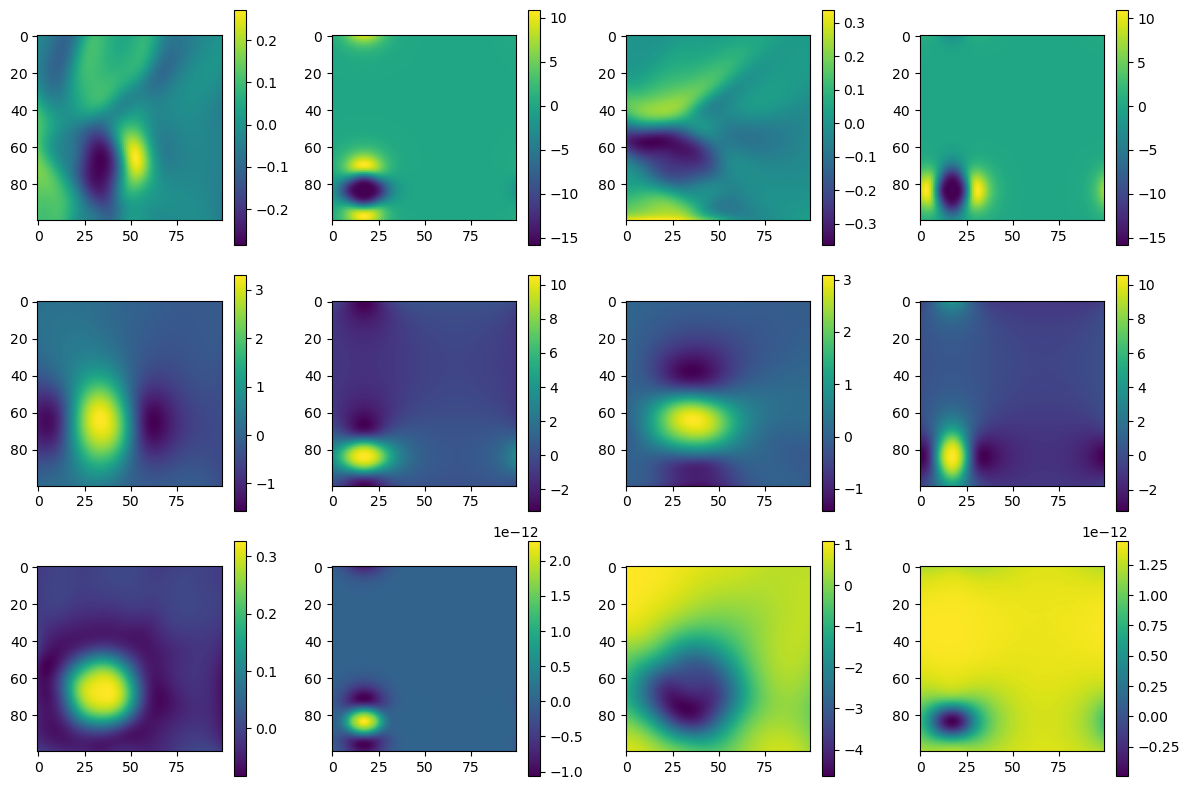

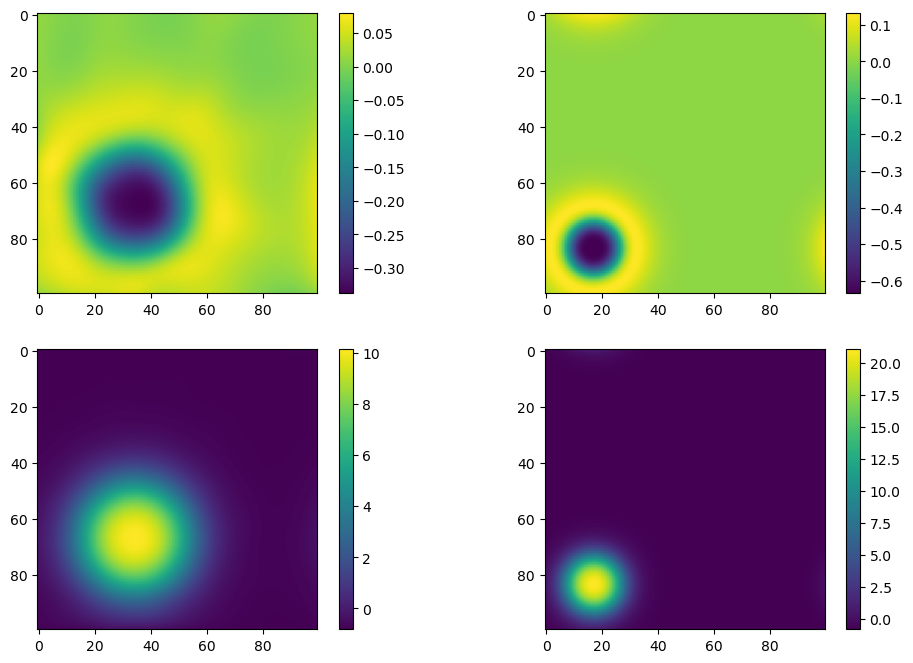

In [25]:
def to(arr):
    return arr.numpy().reshape(ts.shape[0], x_range.shape[0], y_range.shape[0])

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx2)[-1, ...])
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy2)[-1, ...])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx2)[-1, ...])
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy2)[-1, ...])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t2)[-1, ...])
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t2)[-1, ...])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(pattern.params["D_u"]*( to(u_xx2)[-1, ...] + to(u_yy2)[-1, ...]) - to(u_t2)[-1, ...])
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.params["D_v"]*( to(v_xx2)[-1, ...] + to(v_yy2)[-1, ...]) - to(v_t2)[-1, ...])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

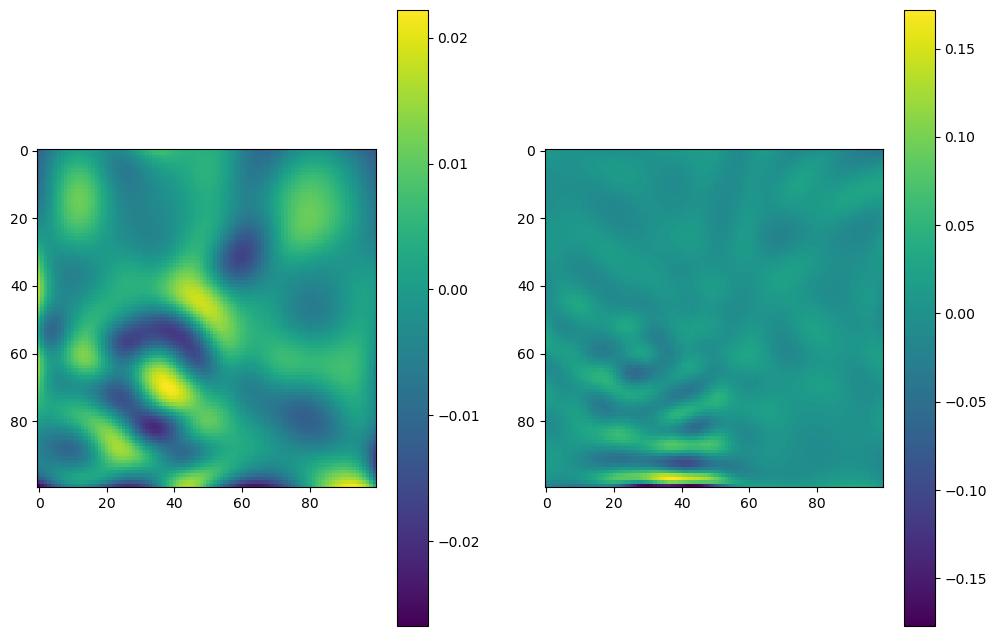

In [26]:
diff_u_diff = ((pattern.params["D_u"]*( to(u_xx)[-1, ...] + to(u_yy)[-1, ...]) - to(u_t)[-1, ...])
               -(pattern.params["D_u"]*( to(u_xx2)[-1, ...] + to(u_yy2)[-1, ...]) - to(u_t2)[-1, ...]))
diff_v_diff = ((pattern.params["D_v"]*( to(v_xx)[-1, ...] + to(v_yy)[-1, ...]) - to(v_t)[-1, ...])
               -(pattern.params["D_v"]*( to(v_xx2)[-1, ...] + to(v_yy2)[-1, ...]) - to(v_t2)[-1, ...]))
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(diff_u_diff)
plt.colorbar()
plt.subplot(122)
plt.imshow(diff_v_diff)
plt.colorbar()
